In [1]:
import torch
import torch.nn as nn
from jcopdl.callback import Callback, set_config
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Jayy\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset & DataLoader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
# kalo bentukanya data tabular, tinggal ganti image folder jadi tensor dataset
# train_set = datasets.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
# kalo bentuknya speech, tinggal ganti image folder jadi audio folder
# train_set = datasets.AudioFolder("../../data neural network/train", transform=transforms.ToTensor())

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])

# kalo bentuknya image, tinggal ganti tensor dataset jadi image folder
train_set = datasets.ImageFolder("../../data neural network/train", transform=transform)
test_set = datasets.ImageFolder("../../data neural network/test", transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=4)

In [4]:
images, labels = next(iter(train_loader))

In [5]:
# MCHW (batch / jumlah gambar, channel, height, width)
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [6]:
train_set.class_to_idx

{'Ankle boot': 0,
 'Bag': 1,
 'Coat': 2,
 'Dress': 3,
 'Pullover': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'T-shirt or Top': 8,
 'Trouser': 9}

In [7]:
label2cat = train_set.classes

In [8]:
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Arsitektur & Config

In [9]:
from jcopdl.layers import linear_block

In [10]:
class fashionClf(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(784, 512, dropout=0.2, batch_norm=True),
            linear_block(512, 256, dropout=0.2, batch_norm=True),
            linear_block(256, 128, dropout=0.2, batch_norm=True),
            linear_block(128, 64, dropout=0.2, batch_norm=True),
            linear_block(64, 10, activation="lsoftmax", batch_norm=False)
        )
        
    def forward(self, x):
        return self.fc(x)

model = fashionClf().to(device)
model

fashionClf(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (

In [11]:
config = set_config({
  "input_size":784, 
  "n1":256, 
  "n2":64, 
  "output_size":len(train_set.classes),
  "dropout":0.2
})

In [12]:
class fashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=dropout, batch_norm=True),
            linear_block(n1, n2, dropout=0.2, batch_norm=True),
            linear_block(n2, output_size, activation="lsoftmax", batch_norm=False)
        )
        
    def forward(self, x):
        return self.fc(x)

# cari set config yg bukan dari wira

model = fashionClassifier(input_size=784, n1=256, n2=64, output_size=len(train_set.classes)).to(device)

# Training Preparation => MCOC

In [13]:
model = fashionClassifier(input_size=784, n1=256, n2=64, output_size=len(train_set.classes)).to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
callback = Callback(model, config, outdir="model")

# Training

In [14]:
from tqdm.auto import tqdm

def loop(mode, datasets, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    else:
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        cost += loss.item() * len(feature)
        correct += (output.argmax(dim=1) == target).sum().item()
    cost /= len(datasets)
    acc = correct / len(datasets)
    return cost, acc


In [15]:
# def train(model, criterion, optimizer, train_loader, test_loader, device, epochs=10):
#     for epoch in range(1, epochs+1):
#         train_cost, train_acc = loop("train", train_loader.dataset, train_loader, model, criterion, optimizer, device)
#         test_cost, test_acc = loop("test", test_loader.dataset, test_loader, model, criterion, optimizer, device)
#         print(f"Epoch {epoch:2d} | train_cost: {train_cost:.4f} | train_acc: {train_acc:.4f} | test_cost: {test_cost:.4f} | test_acc: {test_acc:.4f}")
    
# train(model, criterion, optimizer, train_loader, test_loader, device, epochs=10)

Test: 100%|██████████| 157/157 [00:48<00:00,  3.23it/s]



Epoch     1
Train_cost  = 0.5520 | Test_cost  = 0.8008 | Train_score = 0.4090 | Test_score = 0.8547 |


Test: 100%|██████████| 157/157 [00:14<00:00, 10.59it/s]



Epoch     2
Train_cost  = 0.4234 | Test_cost  = 0.8486 | Train_score = 0.3733 | Test_score = 0.8579 |


Test: 100%|██████████| 157/157 [00:14<00:00, 10.51it/s]



Epoch     3
Train_cost  = 0.3833 | Test_cost  = 0.8615 | Train_score = 0.3876 | Test_score = 0.8539 |
==> EarlyStop patience =  1 | Best test_score: 0.8579


Test: 100%|██████████| 157/157 [00:11<00:00, 13.44it/s]



Epoch     4
Train_cost  = 0.3554 | Test_cost  = 0.8711 | Train_score = 0.3525 | Test_score = 0.8717 |


Test: 100%|██████████| 157/157 [00:11<00:00, 13.67it/s]



Epoch     5
Train_cost  = 0.3415 | Test_cost  = 0.8782 | Train_score = 0.3421 | Test_score = 0.8743 |


Test: 100%|██████████| 157/157 [00:11<00:00, 13.57it/s]



Epoch     6
Train_cost  = 0.3269 | Test_cost  = 0.8780 | Train_score = 0.3465 | Test_score = 0.8710 |
==> EarlyStop patience =  1 | Best test_score: 0.8743


Test: 100%|██████████| 157/157 [00:11<00:00, 13.63it/s]



Epoch     7
Train_cost  = 0.3164 | Test_cost  = 0.8849 | Train_score = 0.3255 | Test_score = 0.8797 |


Test: 100%|██████████| 157/157 [00:12<00:00, 12.92it/s]



Epoch     8
Train_cost  = 0.3011 | Test_cost  = 0.8898 | Train_score = 0.3231 | Test_score = 0.8801 |


Test: 100%|██████████| 157/157 [00:14<00:00, 10.82it/s]



Epoch     9
Train_cost  = 0.2952 | Test_cost  = 0.8917 | Train_score = 0.3385 | Test_score = 0.8776 |
==> EarlyStop patience =  1 | Best test_score: 0.8801


Test: 100%|██████████| 157/157 [00:14<00:00, 11.00it/s]



Epoch    10
Train_cost  = 0.2875 | Test_cost  = 0.8925 | Train_score = 0.3616 | Test_score = 0.8678 |
==> EarlyStop patience =  2 | Best test_score: 0.8801


Test: 100%|██████████| 157/157 [00:14<00:00, 11.02it/s]



Epoch    11
Train_cost  = 0.2824 | Test_cost  = 0.8967 | Train_score = 0.3368 | Test_score = 0.8786 |
==> EarlyStop patience =  3 | Best test_score: 0.8801


Test: 100%|██████████| 157/157 [00:14<00:00, 10.94it/s]



Epoch    12
Train_cost  = 0.2715 | Test_cost  = 0.8996 | Train_score = 0.3388 | Test_score = 0.8774 |
==> EarlyStop patience =  4 | Best test_score: 0.8801


Test: 100%|██████████| 157/157 [00:12<00:00, 12.31it/s]



Epoch    13
Train_cost  = 0.2629 | Test_cost  = 0.9022 | Train_score = 0.3129 | Test_score = 0.8863 |


Test: 100%|██████████| 157/157 [00:14<00:00, 10.67it/s]



Epoch    14
Train_cost  = 0.2602 | Test_cost  = 0.9030 | Train_score = 0.3244 | Test_score = 0.8817 |
==> EarlyStop patience =  1 | Best test_score: 0.8863


Test: 100%|██████████| 157/157 [00:11<00:00, 13.46it/s]



Epoch    15
Train_cost  = 0.2590 | Test_cost  = 0.9042 | Train_score = 0.3231 | Test_score = 0.8810 |
==> EarlyStop patience =  2 | Best test_score: 0.8863


Test: 100%|██████████| 157/157 [00:14<00:00, 10.86it/s]



Epoch    16
Train_cost  = 0.2548 | Test_cost  = 0.9064 | Train_score = 0.3101 | Test_score = 0.8867 |


Test: 100%|██████████| 157/157 [00:14<00:00, 10.77it/s]



Epoch    17
Train_cost  = 0.2494 | Test_cost  = 0.9074 | Train_score = 0.3239 | Test_score = 0.8831 |
==> EarlyStop patience =  1 | Best test_score: 0.8867


Test: 100%|██████████| 157/157 [00:14<00:00, 11.01it/s]



Epoch    18
Train_cost  = 0.2439 | Test_cost  = 0.9089 | Train_score = 0.3615 | Test_score = 0.8783 |
==> EarlyStop patience =  2 | Best test_score: 0.8867


Test: 100%|██████████| 157/157 [00:14<00:00, 10.97it/s]



Epoch    19
Train_cost  = 0.2414 | Test_cost  = 0.9105 | Train_score = 0.3189 | Test_score = 0.8875 |


Test: 100%|██████████| 157/157 [00:15<00:00, 10.32it/s]



Epoch    20
Train_cost  = 0.2391 | Test_cost  = 0.9118 | Train_score = 0.3328 | Test_score = 0.8792 |


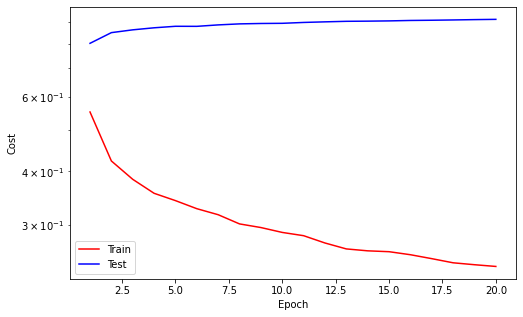

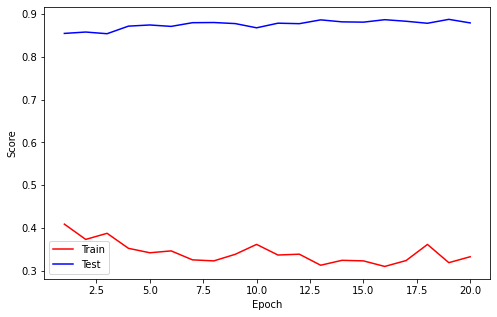

==> EarlyStop patience =  1 | Best test_score: 0.8875


Test: 100%|██████████| 157/157 [00:14<00:00, 10.55it/s]



Epoch    21
Train_cost  = 0.2311 | Test_cost  = 0.9144 | Train_score = 0.3404 | Test_score = 0.8830 |
==> EarlyStop patience =  2 | Best test_score: 0.8875


Test: 100%|██████████| 157/157 [00:14<00:00, 10.53it/s]



Epoch    22
Train_cost  = 0.2274 | Test_cost  = 0.9147 | Train_score = 0.3196 | Test_score = 0.8845 |
==> EarlyStop patience =  3 | Best test_score: 0.8875


Test: 100%|██████████| 157/157 [00:15<00:00, 10.39it/s]



Epoch    23
Train_cost  = 0.2274 | Test_cost  = 0.9143 | Train_score = 0.3168 | Test_score = 0.8865 |
==> EarlyStop patience =  4 | Best test_score: 0.8875


Test: 100%|██████████| 157/157 [00:14<00:00, 10.65it/s]



Epoch    24
Train_cost  = 0.2240 | Test_cost  = 0.9152 | Train_score = 0.3338 | Test_score = 0.8801 |
==> EarlyStop patience =  5 | Best test_score: 0.8875
==> Execute Early Stopping at epoch: 24 | Best test_score: 0.8875
==> Best model is saved at model


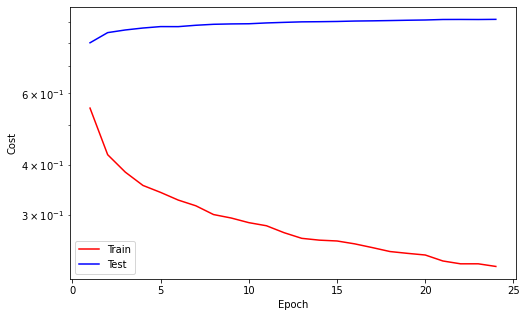

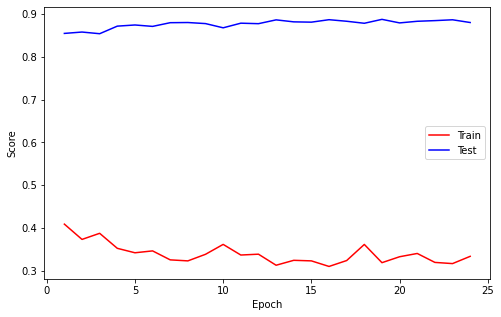

Early stopping


In [16]:
while True:
  train_cost, train_score = loop("train", train_loader.dataset, train_loader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop("test", test_loader.dataset, test_loader, model, criterion, optimizer, device)

  # logging
  callback.log(train_cost, train_score, test_cost, test_score)

  # checkpoint
  callback.save_checkpoint()

  # runtime plot
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  if callback.early_stopping(model, monitor = "test_score"):
    callback.plot_cost()
    callback.plot_score()
    print("Early stopping")
    break
  


# load best model

In [24]:
config = torch.load("model/configs.pth", map_location=device)


weight = torch.load("model/weights_best.pth", map_location=device)


model = fashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
model.load_state_dict(weight)
model = model.to(device)

In [25]:
model

fashionClassifier(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=10, bias=True)
      (1): LogSoftmax(dim=1)
    )
  )
)

# Predict

In [63]:
feature, target  = next(iter(test_loader))
feature, target  = feature.to(device), target.to(device)

In [64]:
with torch.no_grad():
    # predict 
    output = model(feature)
    preds = output.argmax(dim=1)

preds

tensor([6, 9, 8, 4, 1, 0, 1, 0, 6, 5, 0, 0, 7, 7, 1, 1, 2, 8, 4, 1, 5, 0, 8, 0,
        0, 4, 4, 2, 6, 9, 5, 6, 9, 1, 5, 3, 3, 4, 8, 3, 1, 2, 1, 1, 4, 7, 0, 0,
        8, 4, 3, 0, 3, 3, 4, 7, 5, 2, 6, 9, 8, 5, 5, 5, 6, 1, 1, 4, 0, 7, 2, 1,
        4, 2, 1, 1, 6, 7, 0, 0, 6, 5, 2, 0, 8, 3, 4, 6, 6, 0, 2, 2, 0, 0, 9, 0,
        5, 2, 2, 9, 5, 8, 4, 1, 4, 6, 1, 1, 4, 8, 1, 2, 0, 0, 1, 6, 5, 5, 0, 4,
        1, 7, 3, 0, 0, 1, 1, 0])

In [65]:
with torch.no_grad():
    # predict 
    output = model(images.to(device)) # forward pass
    pred = output.argmax(dim=1)
pred

tensor([2, 4, 1, 0, 4, 0, 0, 1, 1, 0, 4, 7, 0, 9, 5, 3, 4, 2, 3, 7, 6, 5, 0, 4,
        3, 6, 8, 6, 9, 0, 9, 2, 5, 7, 9, 7, 6, 9, 8, 8, 5, 0, 5, 6, 1, 4, 9, 5,
        2, 3, 6, 6, 6, 2, 2, 6, 4, 6, 7, 8, 8, 1, 7, 5, 9, 5, 5, 7, 5, 4, 9, 6,
        3, 9, 2, 2, 8, 9, 9, 7, 6, 9, 2, 5, 4, 8, 0, 3, 1, 1, 2, 2, 6, 8, 8, 3,
        1, 6, 3, 5, 4, 7, 4, 1, 3, 7, 3, 0, 4, 7, 1, 5, 7, 5, 9, 8, 2, 2, 8, 1,
        6, 7, 7, 6, 1, 6, 8, 4])

In [66]:
label2cat[3]

'Dress'

In [67]:
[label2cat[i] for i in pred]

['Coat',
 'Pullover',
 'Bag',
 'Ankle boot',
 'Pullover',
 'Ankle boot',
 'Ankle boot',
 'Bag',
 'Bag',
 'Ankle boot',
 'Pullover',
 'Sneaker',
 'Ankle boot',
 'Trouser',
 'Sandal',
 'Dress',
 'Pullover',
 'Coat',
 'Dress',
 'Sneaker',
 'Shirt',
 'Sandal',
 'Ankle boot',
 'Pullover',
 'Dress',
 'Shirt',
 'T-shirt or Top',
 'Shirt',
 'Trouser',
 'Ankle boot',
 'Trouser',
 'Coat',
 'Sandal',
 'Sneaker',
 'Trouser',
 'Sneaker',
 'Shirt',
 'Trouser',
 'T-shirt or Top',
 'T-shirt or Top',
 'Sandal',
 'Ankle boot',
 'Sandal',
 'Shirt',
 'Bag',
 'Pullover',
 'Trouser',
 'Sandal',
 'Coat',
 'Dress',
 'Shirt',
 'Shirt',
 'Shirt',
 'Coat',
 'Coat',
 'Shirt',
 'Pullover',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'T-shirt or Top',
 'Bag',
 'Sneaker',
 'Sandal',
 'Trouser',
 'Sandal',
 'Sandal',
 'Sneaker',
 'Sandal',
 'Pullover',
 'Trouser',
 'Shirt',
 'Dress',
 'Trouser',
 'Coat',
 'Coat',
 'T-shirt or Top',
 'Trouser',
 'Trouser',
 'Sneaker',
 'Shirt',
 'Trouser',
 'Coat',
 'Sandal',
 'Pullover

# Visualisasi

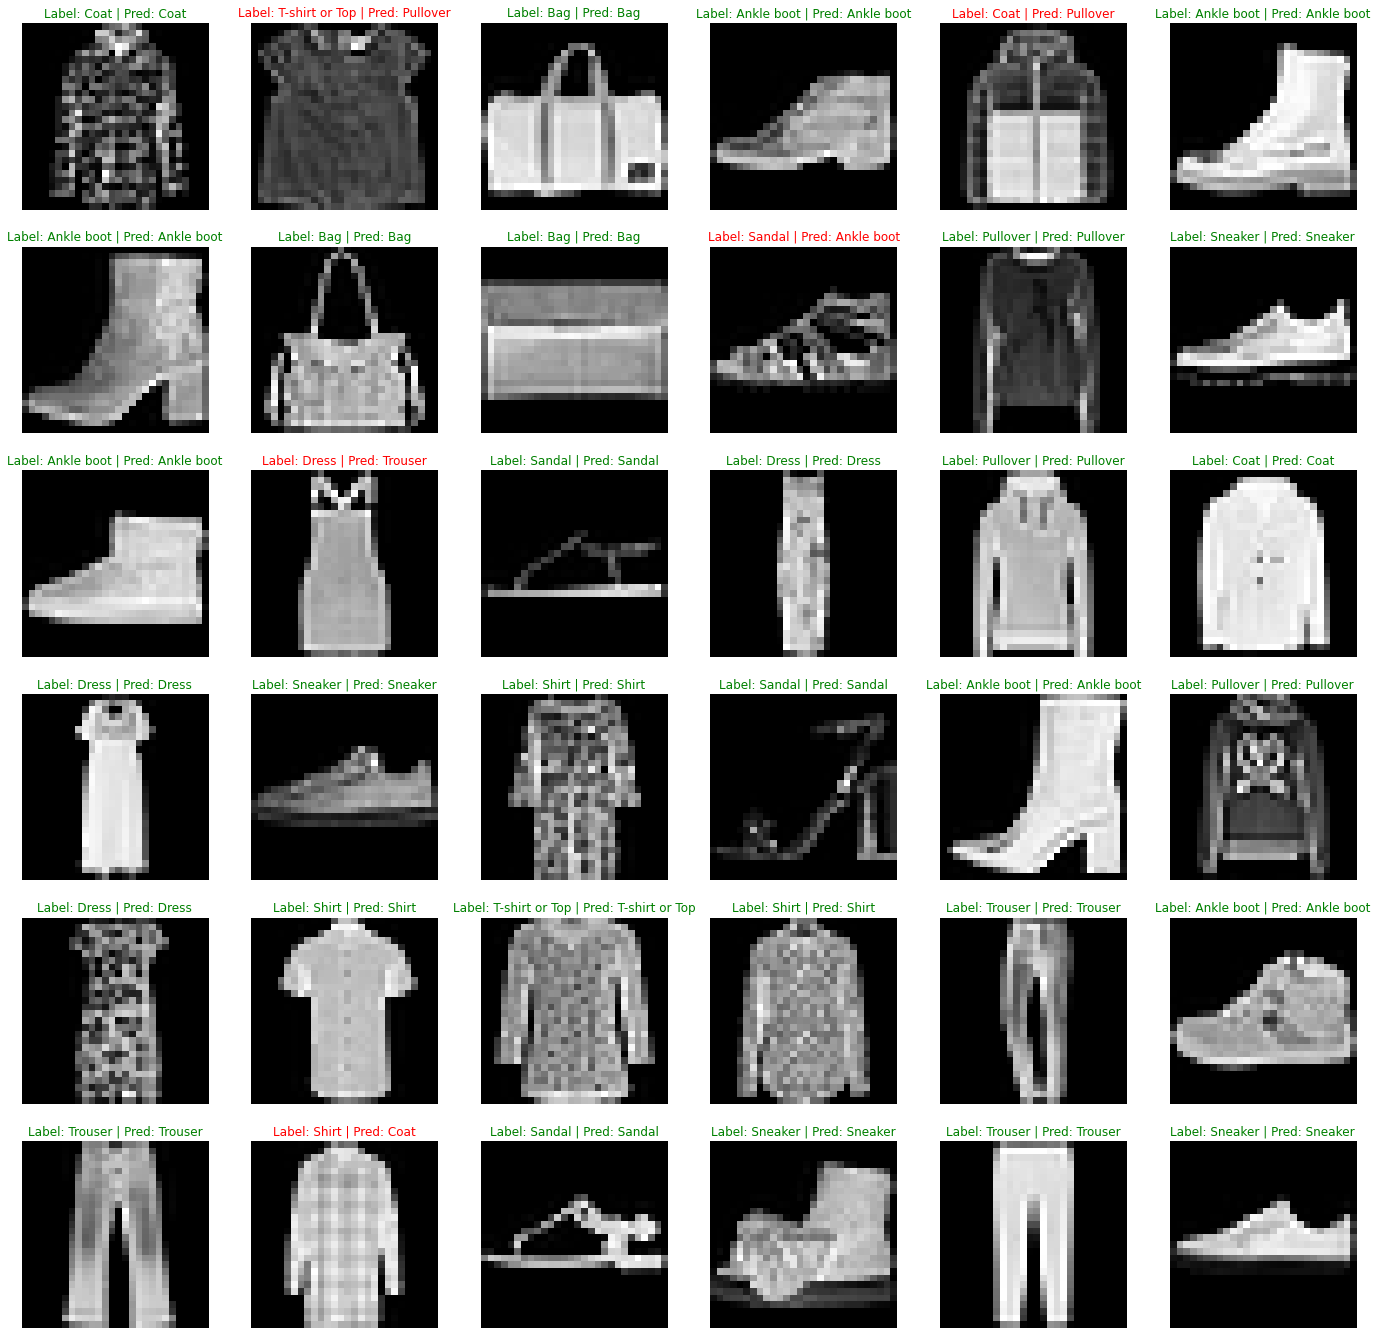

In [68]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(images, labels, pred, ax.flatten()):
    ax.imshow(img.view(28, 28).to(device), cmap="gray")
    font = {"color": "red"} if label != pred else {"color": "green"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font)
    ax.axis("off")

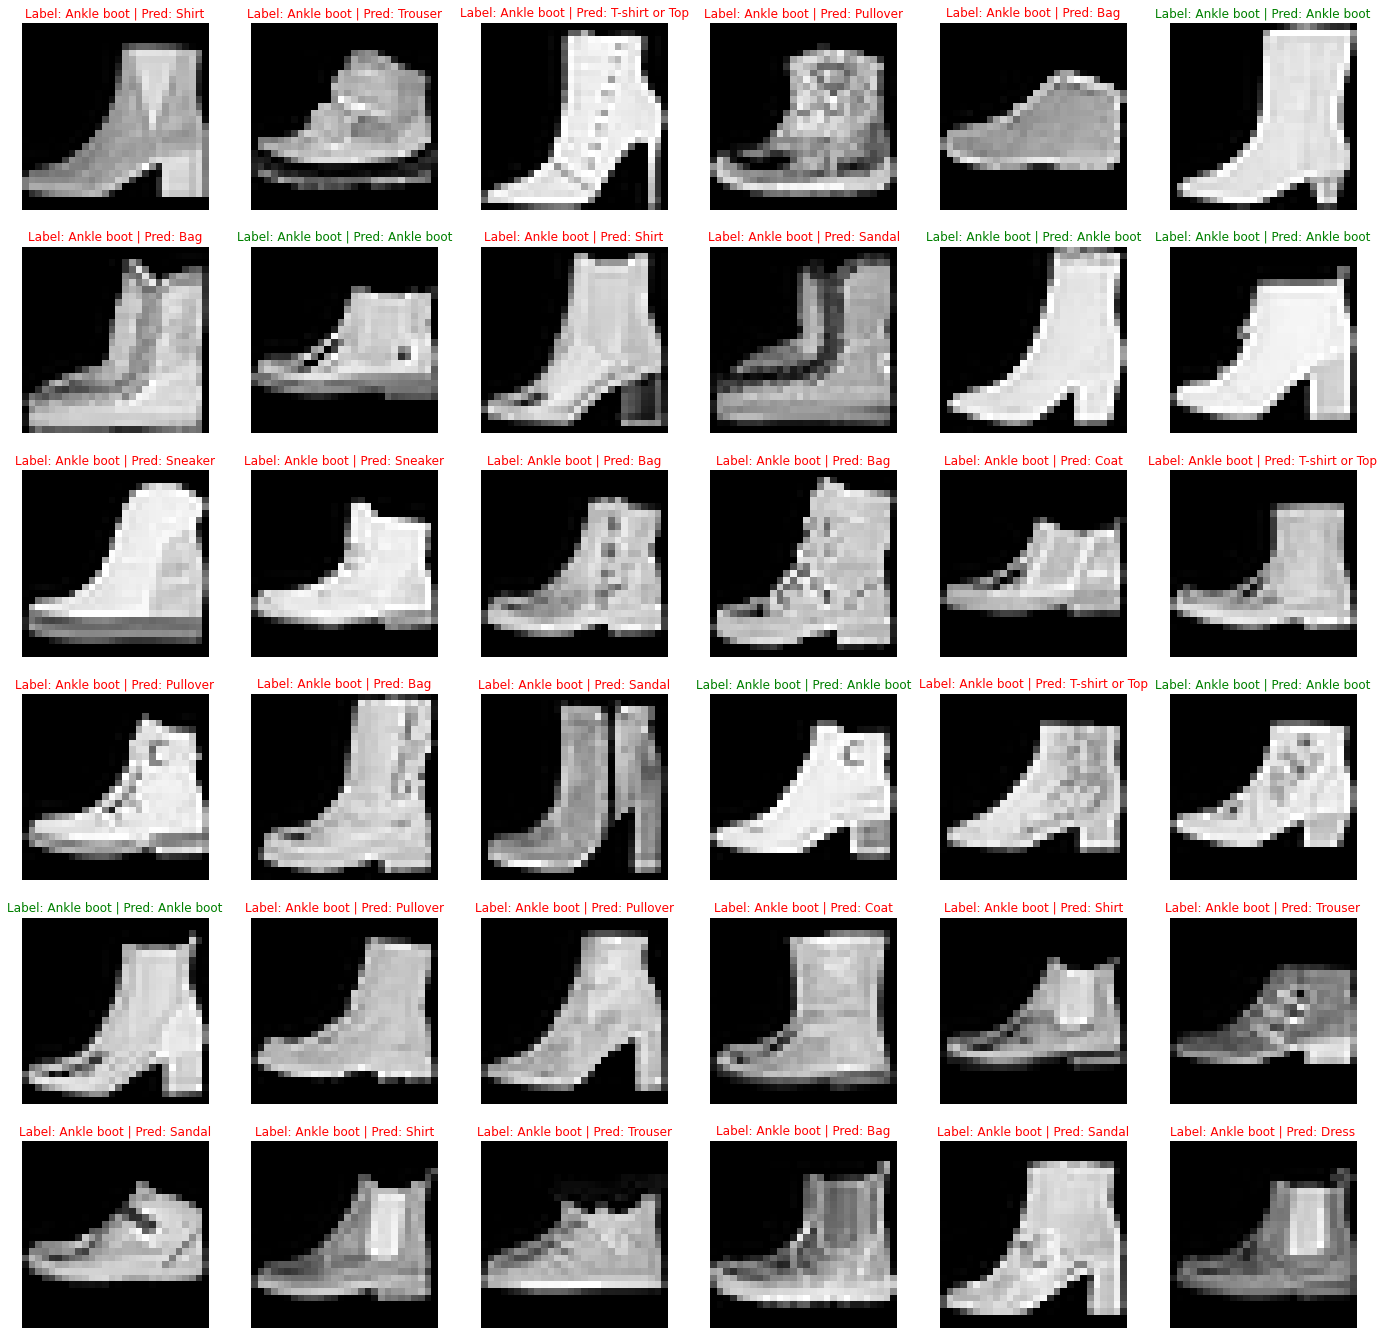

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, ax.flatten()):
    ax.imshow(img.view(28, 28).to(device), cmap="gray")
    font = {"color": "red"} if label != pred else {"color": "green"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font)
    ax.axis("off")

In [ ]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

from torch.utils.data import TensorDataset, DataLoader

bs = "______"

train_set = TensorDataset("________")
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers="__")

test_set = TensorDataset("_________")
testloader = DataLoader(test_set, batch_size=bs, shuffle="____")